# Sanity CNN implemented in caffe

In [44]:
from pylab import *
%matplotlib inline

import sys
import os

caffe_root = '../../../caffe/'

sys.path.insert(0, caffe_root + '/' + 'python')
import caffe

In [45]:
from caffe import layers as L, params as P

train_net_path = 'three_layer_train.prototxt'
test_net_path = 'three_layer_test.prototxt'

def three_layer_sanity_cnn(hdf5, batch_size=25):

    # Conv - ReLU - Pool - Affine - Relu - Affine - Loss
    n = caffe.NetSpec()
    
#     n.data, n.label = L.MemoryData(batch_size = batch_size, channels = channels, width = width, height = height)
#     n.label = L.MemoryData(batch_size = batch_size, channels = 30, width = 1, height = 1)
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=32, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.pool1 = L.Pooling(n.relu1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.fc2 = L.InnerProduct(n.pool1, num_output=100, weight_filler=dict(type='xavier'))
    n.relu2 = L.ReLU(n.fc2, in_place=True)
    
    n.score = L.InnerProduct(n.relu2, num_output=30, weight_filler=dict(type='xavier'))

    n.loss =  L.EuclideanLoss(n.score, n.label)
    
    return n.to_proto()


with open(train_net_path, 'w') as f:
    f.write(str(three_layer_sanity_cnn(hdf5='../data/train.h5list', batch_size=25)))

with open(test_net_path, 'w') as f:
    f.write(str(three_layer_sanity_cnn(hdf5='../data/test.h5list', batch_size=25)))
    
!cat three_layer_train.prototxt

layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "../data/train.h5list"
    batch_size: 25
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 32
    kernel_size: 3
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc2"
  type: "InnerProduct"
  bottom: "pool1"
  top: "fc2"
  inner_product_param {
    num_output: 100
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "fc2"
  top: "fc2"
}
layer {
  name: "score"
  type: "InnerProduct"
  bottom: "fc2"
  top: "score"
  inner_product_param {
    num_output: 30
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "loss

In [46]:
solver_config_path = 'three_layer_auto_solver.prototxt'
### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
# s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path

# Add train and test nets both. Train net to give training accuracy. Test net to give validation accuracy
s.test_net.append(train_net_path)
s.test_net.append(test_net_path)
s.test_interval = 10  # Test after every 500 training iterations.
s.test_iter.append(2) # Test on 4 batches each time we test.
s.test_iter.append(20) # Test on 4 batches each time we test.

s.max_iter = 1000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "Adam"

# Set the initial learning rate for SGD.
s.base_lr = 0.00001  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 5e-4

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'step'
s.stepsize = 100 #drop the learning rate every stepsize.

s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 2

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 500
s.snapshot_prefix = 'three_layer_sanity'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.CPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

!cat three_layer_auto_solver.prototxt

train_net: "three_layer_train.prototxt"
test_net: "three_layer_train.prototxt"
test_net: "three_layer_test.prototxt"
test_iter: 2
test_iter: 20
test_interval: 10
base_lr: 1e-05
display: 2
max_iter: 1000
lr_policy: "step"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
stepsize: 100
snapshot: 500
snapshot_prefix: "three_layer_sanity"
solver_mode: CPU
type: "Adam"


In [47]:
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver('three_layer_auto_solver.prototxt')


In [48]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (25, 1, 96, 96)),
 ('label', (25, 30)),
 ('conv1', (25, 32, 94, 94)),
 ('pool1', (25, 32, 47, 47)),
 ('fc2', (25, 100)),
 ('score', (25, 30)),
 ('loss', ())]

In [49]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (32, 1, 3, 3)), ('fc2', (100, 70688)), ('score', (30, 100))]

In [50]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(64468.8046875, dtype=float32)}

(-0.5, 575.5, 95.5, -0.5)

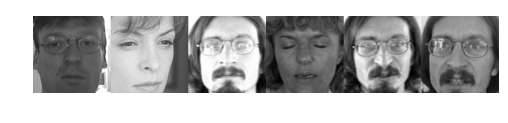

In [51]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:6, 0].transpose(1, 0, 2).reshape(96, 6*96), cmap='gray'); axis('off')
#print 'train labels:', solver.net.blobs['label'].data[:4]

(-0.5, 575.5, 95.5, -0.5)

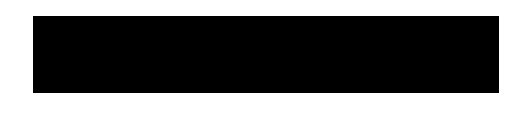

In [52]:
imshow(solver.test_nets[1].blobs['data'].data[:6, 0].transpose(1, 0, 2).reshape(96, 6*96), cmap='gray'); axis('off')

## Stepping the solver

In [53]:
solver.step(1)

(-0.5, 8.5, 31.5, -0.5)

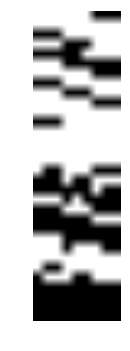

In [54]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(8, 4, 3, 3)
       .transpose(0, 2, 1, 3).reshape(4*8, 3*3), cmap='gray'); axis('off')

In [ ]:
%%time
niter = 40
test_interval = 2
# losses will also be stored in the log
train_loss = zeros(niter)


train_acc = zeros(int(np.ceil(niter / test_interval)))
val_acc = zeros(int(np.ceil(niter / test_interval)))
#output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    #solver.test_nets[0].forward(start='conv1')
    #output[it] = solver.test_nets[0].blobs['score'].data[:8]
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        train_error = 0
        val_error = 0
        for test_it in range(2):
            solver.test_nets[0].forward()
            solver.test_nets[1].forward()
            
            train_error += np.mean( (solver.test_nets[0].blobs['score'].data 
                                  - solver.test_nets[0].blobs['label'].data) ** 2)
            val_error += np.mean( (solver.test_nets[1].blobs['score'].data 
                                  - solver.test_nets[1].blobs['label'].data) ** 2)
        
        train_acc[it // test_interval] = train_error
        val_acc[it // test_interval] = val_error
        print "it = %d, training_loss = %f, train_acc = %f, val_acc = %f" % (it, train_loss[it], train_error, val_error)

Iteration 0 testing...
it = 0, training_loss = 3408.524414, train_acc = 451.324326, val_acc = 707.261810
Iteration 2 testing...
it = 2, training_loss = 3275.668945, train_acc = 428.755264, val_acc = 852.414429
Iteration 4 testing...
it = 4, training_loss = 3141.488770, train_acc = 406.589035, val_acc = 630.277649
Iteration 6 testing...
it = 6, training_loss = 3041.802490, train_acc = 389.093857, val_acc = 868.496613


In [ ]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss, 'k')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')

ax2.plot(test_interval * arange(len(train_acc)), train_acc, 'r', label='train_acc')
ax2.plot(test_interval * arange(len(val_acc)), val_acc, 'b', label='val_acc')
ax2.set_ylabel('test and val accuracy')
ax2.legend()
ax2.set_title('Custom Val Accuracy: {:.2f}'.format(val_acc[-1]))
